<a href="https://colab.research.google.com/github/Soobian/deeplearning-project-f1/blob/simple-model/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with EfficientNetB0 trained with in-game data

## Import model

*   Input size: 224 x 224 px
*   Model class: EfficientNetB0
*   Batch size: 32
*   Epochs: 150




In [139]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive


In [140]:
from tensorflow.keras.applications import EfficientNetB0


In [141]:
# Set model constants
INPUT_SIZE = (224, 224)
MODEL_CLASS = EfficientNetB0
BATCH_SIZE = 16
EPOCHS = 150

## Set up data

*   Only in-game data for training, validation and testing


In [142]:
# Connect to Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Game_Dataset/test'


In [144]:
# Get dataset from directory
def get_data_from_dir(dir, batch_size=BATCH_SIZE, input_size=INPUT_SIZE):
  data = keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(input_size[0], input_size[1]),
        shuffle=True
    )

  return data

In [145]:
# Get datasets and create a mixed dataset
def prepare_data(input_size=INPUT_SIZE):
    # Training data
    train_data = get_data_from_dir(train_dir)

    # Validation data
    val_data = get_data_from_dir(val_dir)

    # Test data
    test_data = get_data_from_dir(test_dir)

    # Prefetch to optimize performance
    train_data = train_data.prefetch(tf.data.AUTOTUNE)
    val_data = val_data.prefetch(tf.data.AUTOTUNE)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    return train_data, val_data, test_data

In [146]:
# Prepare data with the specified input size and mixing ratio
print(f"Preparing data for EfficientNetB0 with input size {INPUT_SIZE}")
train_data, val_data, test_data = prepare_data()


Preparing data for EfficientNetB0 with input size (224, 224)
Found 6288 files belonging to 10 classes.
Found 790 files belonging to 10 classes.
Found 780 files belonging to 10 classes.


## Show dataset examples

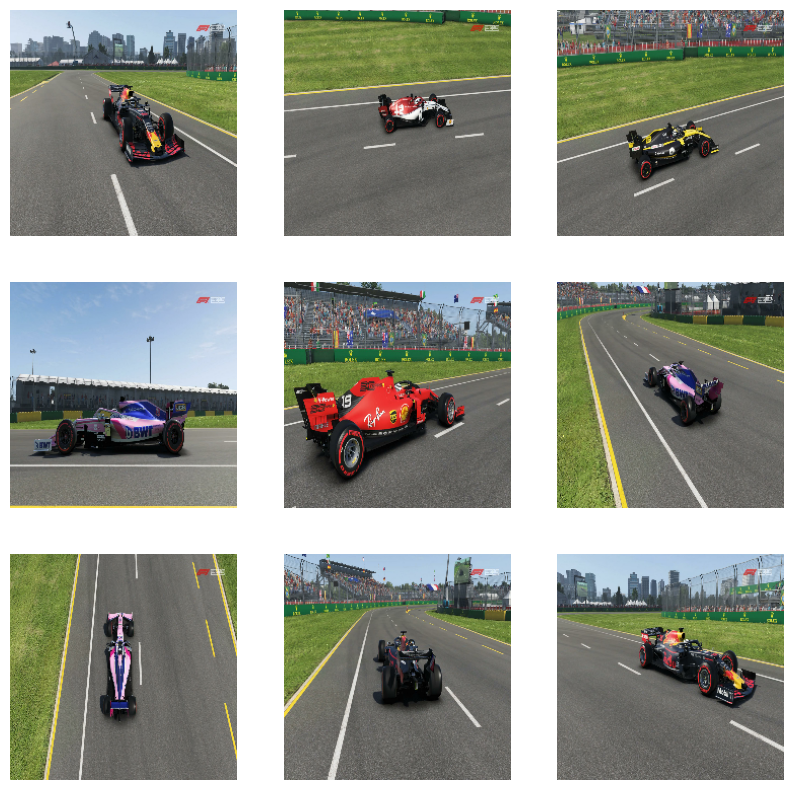

In [ ]:
# Show image from dataset classes
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = np.argmax(labels[i])
        plt.axis("off")

## Creating the model

*   Freeze the base model
*   Single dense layer



In [149]:
def create_model(base_model_class=MODEL_CLASS, input_size=INPUT_SIZE):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Single dense layer
    x = Dense(64, activation='relu')(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [150]:
model = create_model()

print(f"Model created for {MODEL_CLASS} with input size {INPUT_SIZE}.")

# Compile the model using SGD optimizer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model created for <function EfficientNetB0 at 0x7e81266edc60> with input size (224, 224).


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,132,205 (15.76 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Training and testing models

### Plot the training data

In [ ]:
# Plot the training and validation data
def plot_history(history):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

### Train and evaluate model

In [ ]:
# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return len(data) / batch_size

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)

In [ ]:
def save_model(model, path=MODEL_SAVE_PATH):
  # Save the model with a timestamped filename
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  model_save_path = f"{MODEL_SAVE_PATH}model_{timestamp}.keras"
  model.save(model_save_path)

In [ ]:
def show_results(history, test_loss, test_accuracy):
  # Plot the training and validation data
  plot_history(history)

  # Get the final training and validation loss and accuracy
  train_loss = history.history['loss'][-1]
  train_accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  print(f"Training Loss: {train_loss:.4f}")
  print(f"Training Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {val_loss:.4f}")
  print(f"Validation Accuracy: {val_accuracy:.4f}")

  # Print the test loss and accuracy
  print(f"Test Loss: {test_loss:.4f}")
  print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
import pandas as pd
import gc
from datetime import datetime

MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'

def train_evaluate_model(model, train_data, val_data, test_data, batch_size=BATCH_SIZE, epochs=EPOCHS):
  # Train the model and capture the training history
  history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
  )
  # Evaluate model performance on test data
  test_loss, test_accuracy = model.evaluate(test_data)

  save_model(model, MODEL_SAVE_PATH)

  show_results(history, test_loss, test_accuracy)


ValueError: When providing `x` as a tf.data.Dataset, `y` should not be passed. Instead, the targets should be included as part of the tf.data.Dataset.